# Inside StackOverflow 
## Data Science Project: Who and what is popular on StackOverflow? 
### by Mehmet Solmaz, 5/12/2019

#### The project consists of 3 parts. 

**1.**	Identifying the 20 mostly used tags in Posts:<br>
        &emsp;a.	Ranking in the last 5 years vs. Total rank <br>
        &emsp;b.  How many tags are programming languages? <br>
**2.**	Finding the most reputable users:<br>
        &emsp;a.	Find out the most reputable user in **Python** programming language <br>
        &emsp;b. Identify top 5 other software skills that go with **Python**.<br>
**3.**	Extract insights about **Python** programming language.<br>
        &emsp;a.	Find most important topics for users by Topic Modelling. 

**The data read from CSV files are downloaded using custom SQL queries on StackExchange Data Explorer: <br> (https://data.stackexchange.com/stackoverflow/query/new). These SQL query files are shared in this project as well.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
import requests
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from collections import Counter
from gensim import models, corpora
import gensim
import os
import spacy
import pyLDAvis.gensim as gensimvis
import pyLDAvis

## Part 1
### Top 20 most used tags in Posts (Total Rank vs. Last 5 Year Rank)

In [2]:
# CSV file was created using stack1.sql file
top_tags = pd.read_csv('./data/1.csv',delim_whitespace=False, index_col='Tag')

In [3]:
# peak at dataframe
top_tags.head()

,RankLast5Years,TotalRank,QuestionsSince2015,QuestionsTotal
Tag,,,,
javascript,1,1,1067087,1792816
java,2,2,798440,1536073
python,3,6,787042,1149285
php,4,4,623266,1276074
android,5,5,619078,1186711


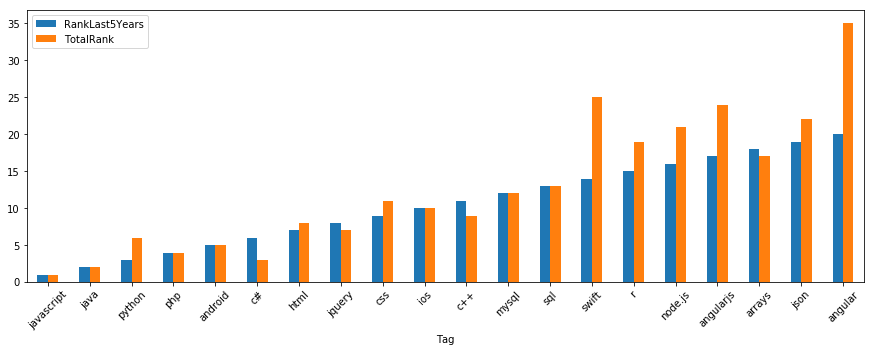

In [4]:
ax = top_tags.plot(kind = 'bar',y=['RankLast5Years','TotalRank'], rot=45,figsize=(15,5));
plt.show()

#### Looks like top 4 tags are programming languages. We could also create a look-up table for programming languages and filter the top Tags that are programming languages.

## Part 2
### Finding the most reputable users
#### a. Find out the most reputable user in Python programming language


In [5]:
# CSV file was created using stack2.sql file
users_rep = pd.read_csv('./data/2-python.csv',delim_whitespace=False, index_col='DisplayName')

In [6]:
# peak at Top Python users
users_rep.head()

,User Link,Reputation,Answers,Score,Avg
DisplayName,,,,,
Martijn Pieters,100297,729986,18658,116630,6.3
unutbu,190597,565374,6867,60451,8.8
Alex Martelli,95810,638448,4413,58646,13.3
Sven Marnach,279627,362738,2055,35397,17.2
Ignacio Vazquez-Abrams,20862,594610,5624,35061,6.2


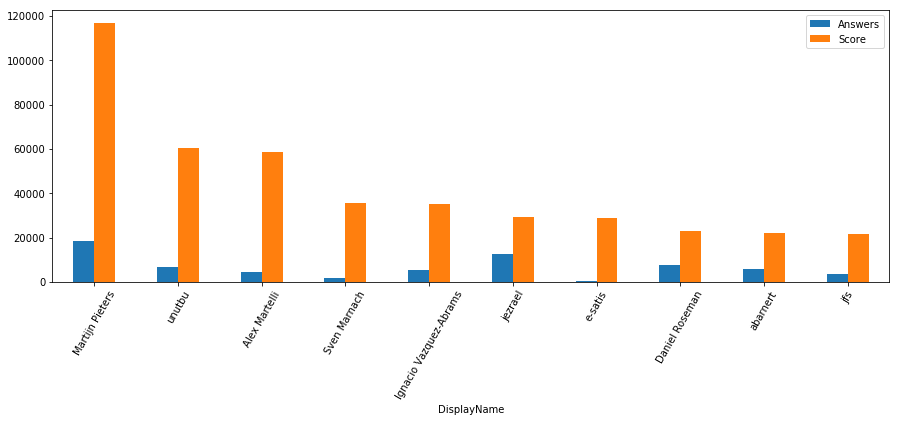

In [7]:
# plot users' # of answers and total score obtained
ax = users_rep[:10].plot(kind = 'bar', y=['Answers','Score'], rot=60,figsize=(15,5));
plt.show()

#### The ranking was based on the total score for Posts with Python tag. Martijn Pieters is leading with Total Score metric. Another metric could be Score/Answer, or Avg column.

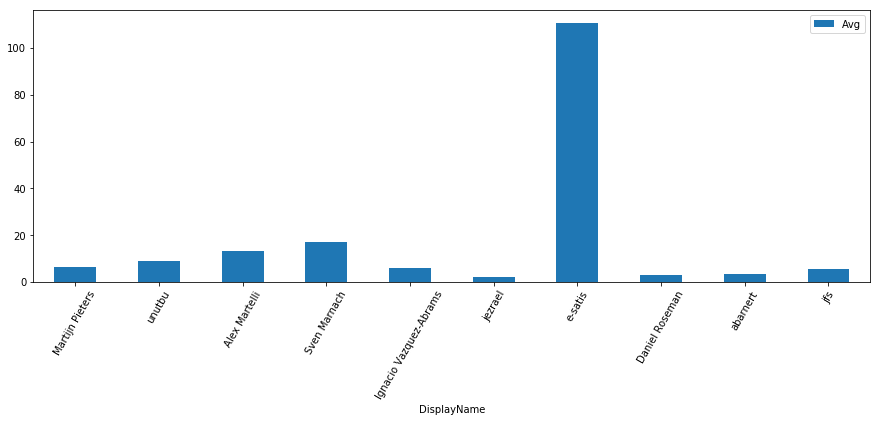

In [8]:
ax = users_rep[:10].plot(kind = 'bar', y=['Avg'], rot=60,figsize=(15,5));
plt.show()

User **e-satis** is clearly the most reputable answerer with ~110 average score. 

#### b. Identify top 5 other software skills that go with Python.

In [9]:
# CSV file was created using stack2_2.sql file
top_skills = pd.read_csv('./data/2-tags.csv',delim_whitespace=False)

In [10]:
# the sql query obtained all the post tags that the Top 1000 most reputable users answered to.
# lets peak at the dataframe
top_skills.head(10)

,DisplayName,tagname,Score
0,Jon Skeet,c#,228834
1,Jon Skeet,java,135462
2,Martijn Pieters,python,116981
3,Jon Skeet,.net,81655
4,unutbu,python,60664
5,Alex Martelli,python,58746
6,Felix Kling,javascript,39146
7,Sven Marnach,python,35476
8,Ignacio Vazquez-Abrams,python,35122
9,Greg Hewgill,git,34337


In [11]:
# First we need to remove every tag related to Python
# We dont need to include it.
programming_language = 'python'

In [12]:
# make the column type string
top_skills['tagname']= top_skills['tagname'].astype(str)

In [13]:
# remove rows with Python like string
top_skills = top_skills[~top_skills.tagname.str.contains(programming_language)]

In [14]:
# since we have all the tags user has, and we need remove all but Top 5
# First, sort by User Name and Score
top_skills = top_skills.sort_values(by=['DisplayName', 'Score'], ascending=False)

In [15]:
top_skills.head()

,DisplayName,tagname,Score
13770,ʇsәɹoɈ,join,215
13776,ʇsәɹoɈ,filenames,215
17053,ʇsәɹoɈ,django,167
17837,ʇsәɹoɈ,postgresql,159
17907,ʇsәɹoɈ,psycopg2,159


In [16]:
# filter out all but Top 5 tags from each user
top_skills_5 = top_skills.groupby('DisplayName').head(5)

In [17]:
top_skills_5.head(5)

,DisplayName,tagname,Score
13770,ʇsәɹoɈ,join,215
13776,ʇsәɹoɈ,filenames,215
17053,ʇsәɹoɈ,django,167
17837,ʇsәɹoɈ,postgresql,159
17907,ʇsәɹoɈ,psycopg2,159


In [18]:
# Find the count of unique values in tagname column to look at most used 10 tags
top_skills_5['tagname'].value_counts().head(10)

list          236
numpy         161
string        160
dictionary    143
django        129
javascript    127
pandas        110
java          104
c++           102
c              90
Name: tagname, dtype: int64

**list**, **numpy**, **string**, **dictionary** and **django** are the top 5 skills most reputable Python users have. 

It is also important to note that users are equipped with multiple programming language skills.

## Part 3
### Extract insights about Python programming language



In [19]:
# CSV file has StackoverFlow Post Link, Title, QuestionBody and Answerbody. Answers are from each user and are tied to each post.
# It was created using stack3.sql file
posts = pd.read_csv('./data/3-python.csv',delim_whitespace=False)

In [20]:
# peak at queried data
posts.head()

,Post Link,Post_Title,Score,QuestionBody,AnswerBody
0,231767,"What does the ""yield"" keyword do?",9169,<p>What is the use of the <code>yield</code> k...,<p><code>yield</code> is just like <code>retur...
1,231767,"What does the ""yield"" keyword do?",9169,<p>What is the use of the <code>yield</code> k...,<p>It's returning a generator. I'm not particu...
2,231767,"What does the ""yield"" keyword do?",9169,<p>What is the use of the <code>yield</code> k...,<p>Think of it this way:</p>\n\n<p>An iterator...
3,231767,"What does the ""yield"" keyword do?",9169,<p>What is the use of the <code>yield</code> k...,"<p>To understand what <code>yield</code> does,..."
4,231767,"What does the ""yield"" keyword do?",9169,<p>What is the use of the <code>yield</code> k...,<p>Here is an example in plain language. I wil...


**The dataframe consists of Post Link, Post Title, Score, Question Body and Answer Body. Every row contains 1 answer for the post.**

In [21]:
# Helper function to remove preformatted text (i.e. python code)
def remove_pre_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    for p in soup.find_all('pre'):
        if p.string:
            p.replace_with(" ")
    stripped_text = soup.get_text()
    return stripped_text

# Helper function to parse data from html using Beautiful Soup
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

**Lets clean the Question and Answer Bodies by removing all the preformatted text (code), and use BeautifulSoup for the rest.**

In [22]:
# remove code from Question Body
posts['QuestionBody'] = posts['QuestionBody'].apply(remove_pre_tags)

In [23]:
# extra cleaning with Beautiful Soup
posts['QuestionBody'] = posts['QuestionBody'].apply(remove_html_tags)

In [24]:
# remove code from Answer Body
posts['AnswerBody'] = posts['AnswerBody'].apply(remove_pre_tags)

In [25]:
# extra cleaning with Beautiful Soup
posts['AnswerBody'] = posts['AnswerBody'].apply(remove_html_tags)

In [26]:
# lets see how clean the data looks.
posts.head(3)

,Post Link,Post_Title,Score,QuestionBody,AnswerBody
0,231767,"What does the ""yield"" keyword do?",9169,What is the use of the yield keyword in Python...,yield is just like return - it returns whateve...
1,231767,"What does the ""yield"" keyword do?",9169,What is the use of the yield keyword in Python...,It's returning a generator. I'm not particular...
2,231767,"What does the ""yield"" keyword do?",9169,What is the use of the yield keyword in Python...,Think of it this way:\nAn iterator is just a f...


In [27]:
# Lets group individuals posts together by combining its title, question body and answer body and
# create a new dataframe. Pivot table is a good choice here.
table = pd.pivot_table(posts, values='AnswerBody', index=['Post Link', 'Post_Title', 'Score', 'QuestionBody']
                    , aggfunc=lambda x: ''.join(x)).reset_index()

In [28]:
# total number of posts is an important metric when we do Topic Modeling. 
table.shape

(4830, 5)

In [29]:
# Combine Post Title, Question Body and Answer Body for each Post Link to the new all_data column
table['all_data'] = table['Post_Title'].map(str) + ' ' + table['QuestionBody'].map(str) + ' ' + table['AnswerBody']

In [30]:
table.head(3)

,Post Link,Post_Title,Score,QuestionBody,AnswerBody,all_data
0,337,XML Processing in Python,67,I am about to build a piece of a project that ...,"Personally, I've played with several of the bu...",XML Processing in Python I am about to build a...
1,535,Continuous Integration System for a Python Cod...,54,I am starting to work on a hobby project with ...,One possibility is Hudson. It's written in Ja...,Continuous Integration System for a Python Cod...
2,683,Using 'in' to match an attribute of Python obj...,43,I don't remember whether I was dreaming or not...,"No, you were not dreaming. Python has a prett...",Using 'in' to match an attribute of Python obj...


In [31]:
# Lets look at 1 cell to make sure everything is combined
table['all_data'][0]

'XML Processing in Python I am about to build a piece of a project that will need to construct and post an XML document to a web service and I\'d like to do it in Python, as a means to expand my skills in it.  \nUnfortunately, whilst I know the XML model fairly well in .NET, I\'m uncertain what the pros and cons are of the XML models in Python.  \nAnyone have experience doing XML processing in Python? Where would you suggest I start? The XML files I\'ll be building will be fairly simple.\n Personally, I\'ve played with several of the built-in options on an XML-heavy project and have settled on pulldom as the best choice for less complex documents.\nEspecially for small simple stuff, I like the event-driven theory of parsing rather than setting up a whole slew of callbacks for a relatively simple structure.  Here is a good quick discussion of how to use the API.\nWhat I like: you can handle the parsing in a for loop rather than using callbacks.  You also delay full parsing (the "pull" p

In [32]:
# Make a list of cell values, nested list
all_data = table['all_data'].values.tolist()

In [33]:
# Remove new line characters using regex
all_data = [re.sub('\s+', ' ', sent) for sent in all_data]

In [34]:
# look at cell #1 again
all_data[0]

'XML Processing in Python I am about to build a piece of a project that will need to construct and post an XML document to a web service and I\'d like to do it in Python, as a means to expand my skills in it. Unfortunately, whilst I know the XML model fairly well in .NET, I\'m uncertain what the pros and cons are of the XML models in Python. Anyone have experience doing XML processing in Python? Where would you suggest I start? The XML files I\'ll be building will be fairly simple. Personally, I\'ve played with several of the built-in options on an XML-heavy project and have settled on pulldom as the best choice for less complex documents. Especially for small simple stuff, I like the event-driven theory of parsing rather than setting up a whole slew of callbacks for a relatively simple structure. Here is a good quick discussion of how to use the API. What I like: you can handle the parsing in a for loop rather than using callbacks. You also delay full parsing (the "pull" part) and onl

In [35]:
# Gensim method 'simple_process' does basic pre-processing such as tokenization, lowercasing, remove punctuations etc. and returns back a list of tokens (words)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [36]:
# tokenized, lowercased and removed punctuations saved to new list
all_data_words = list(sent_to_words(all_data))

In [37]:
# peak at the words list
all_data_words[0][0:10]

['xml',
 'processing',
 'in',
 'python',
 'am',
 'about',
 'to',
 'build',
 'piece',
 'of']

In [38]:
# Use Gensim to create bigram model for commonly used phrases
# minimum score for a bigram to be taken into account is chosen 50, minimum count is set to 5
bigram = gensim.models.Phrases(all_data_words, min_count=5, threshold=50)
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [39]:
# lets look at bigrams generated
s = bigram_mod[all_data_words[0]]
print([x for x in s if re.search('_', x)])

['xml_document', 'web_service', 'event_driven', 'rather_than', 'rather_than', 'wind_up', 'standard_library', 'straight_forward', 'turned_out', 'data_structures', 'care_about', 'xml_etree', 'strongly_recommend', 'memory_footprint', 'google_appengine', 'xml_document', 'xml_document', 'highly_recommend']


In [40]:
# lets start removing the stop words from our word dictionary
# realized setting stop_words to a set (instead of list) makes processing much faster
stop_words = set(stopwords.words('english'))
list(stop_words)[0:5]

['on', 'have', 'down', 'yourselves', 'him']

In [41]:
# Remove Stop Words
all_data_words_stop_words = [word for word in all_data_words if word not in list(stop_words)]

In [42]:
# create Bigrams
all_data_words_bigrams = [bigram_mod[doc] for doc in all_data_words_stop_words];

In [43]:
all_data_words_bigrams[0][0]

'xml'

In [45]:
# using Spacy module's Part of Speecg tagging, filter out words that are not Proper Noun, Verb present participle, singular noun, and adverb
allowed_tags=['NNP', 'VBG', 'NN', 'RB', ]
nlp = spacy.load('en', disable=['parser', 'ner'])

In [46]:
# lemmatize only words with allowed tags
texts_out = []
for sent in all_data_words_bigrams:
    doc = nlp(" ".join(sent))
    texts_out.append([token.lemma_ for token in doc if token.tag_ in allowed_tags])

In [47]:
# remove the programming language word (Python) from our words
texts_out = [[word for word in doc if word not in programming_language] for doc in texts_out]

In [48]:
all_data_words_tagged = texts_out

In [49]:
# peak at tagged words
all_data_words_tagged[0][0:10]

['xml',
 'processing',
 'piece',
 'project',
 'xml_document',
 'web_service',
 'unfortunately',
 'xml',
 'model',
 'fairly']

In [50]:
# Build a Dictionary - association word to numeric id
dictionary = corpora.Dictionary(all_data_words_tagged)

In [51]:
# filter out tokens that appear in less than 15 documents, keep only the first 100000 most frequent tokens
dictionary.filter_extremes(no_below=15, keep_n=100000)

In [52]:
# Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples
corpus = [dictionary.doc2bow(text) for text in all_data_words_tagged]

In [53]:
print(corpus[3])

[(3, 1), (10, 1), (14, 16), (17, 1), (20, 1), (21, 1), (23, 1), (34, 1), (42, 1), (48, 1), (54, 4), (57, 1), (60, 1), (72, 1), (78, 3), (80, 1), (88, 2), (94, 1), (95, 1), (97, 1), (103, 2), (106, 1), (110, 1), (123, 1), (132, 1), (143, 1), (148, 3), (159, 1), (180, 3), (183, 1), (191, 1), (199, 1), (213, 3), (214, 1), (221, 2), (226, 1), (233, 1), (252, 1), (264, 1), (270, 3), (283, 2), (285, 1), (286, 1), (287, 2), (290, 1), (291, 1), (292, 1), (293, 1), (294, 2), (295, 1), (296, 1), (297, 1), (298, 1), (299, 1), (300, 1), (301, 1), (302, 1), (303, 2), (304, 1), (305, 1), (306, 1), (307, 2), (308, 9), (309, 1), (310, 1), (311, 1), (312, 1), (313, 1), (314, 1), (315, 3), (316, 1), (317, 3), (318, 1), (319, 2), (320, 1), (321, 1), (322, 1), (323, 2), (324, 1), (325, 1), (326, 2), (327, 1), (328, 2), (329, 1), (330, 1), (331, 1), (332, 4), (333, 1), (334, 3), (335, 1), (336, 1), (337, 1), (338, 2), (339, 1), (340, 1), (341, 1), (342, 1), (343, 2), (344, 1), (345, 13), (346, 1)]


In [54]:
# Build the LDA model
# LDA does not need tf-idf to infer topics
num_topics = 20
lda_model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=20)

In [55]:
print("LDA Model:")
 
for idx in range(num_topics):
    # Print the first 10 most representative topics
    print("Topic %s:" % idx, lda_model.print_topic(idx, 8))

LDA Model:
Topic 0: 0.057*"json" + 0.038*"model" + 0.026*"table" + 0.025*"field" + 0.025*"database" + 0.023*"flask" + 0.022*"query" + 0.014*"request"
Topic 1: 0.017*"thread" + 0.015*"server" + 0.014*"com" + 0.014*"library" + 0.009*"time" + 0.009*"page" + 0.009*"run" + 0.009*"process"
Topic 2: 0.039*"notebook" + 0.036*"jupyter" + 0.022*"mysql" + 0.021*"docker" + 0.020*"jupyter_notebook" + 0.019*"cell" + 0.018*"kernel" + 0.015*"ipython"
Topic 3: 0.029*"exception" + 0.028*"none" + 0.024*"loop" + 0.024*"statement" + 0.022*"value" + 0.018*"generator" + 0.015*"something" + 0.014*"return"
Topic 4: 0.127*"module" + 0.071*"import" + 0.049*"test" + 0.037*"package" + 0.031*"file" + 0.025*"name" + 0.017*"directory" + 0.014*"pil"
Topic 5: 0.142*"file" + 0.029*"line" + 0.022*"text" + 0.017*"error" + 0.016*"csv" + 0.014*"encoding" + 0.014*"read" + 0.013*"log"
Topic 6: 0.154*"string" + 0.040*"str" + 0.024*"format" + 0.023*"character" + 0.018*"word" + 0.013*"method" + 0.012*"line" + 0.012*"join"
Topic 

**Now lets plot the importance of words in each Topic based on the LDA Model as a Bar Plot**

/Users/mehmetsolmaz/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


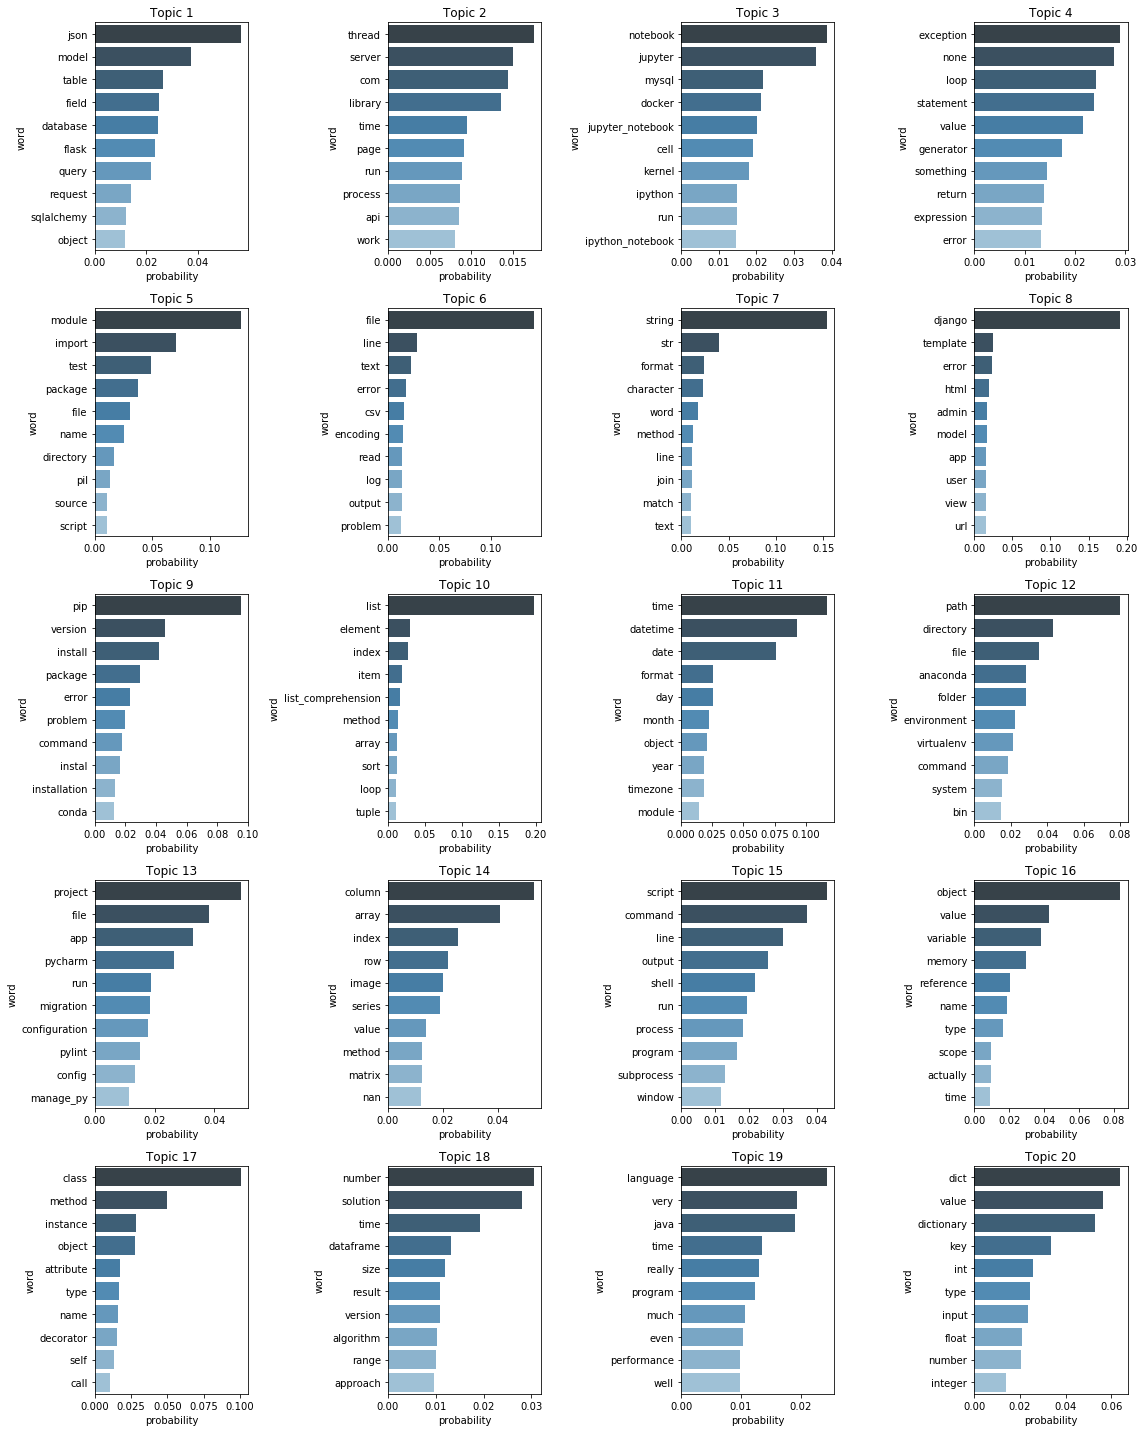

In [56]:
plt.figure(figsize=(16,20))
for i in range(num_topics):
    df=pd.DataFrame(lda_model.show_topic(i), columns=['word','probability'])
    plt.subplot(5,num_topics/5,i+1)
    plt.title('Topic ' + str(i+1))
    sns.barplot(x='probability', y='word', data=df, palette='Blues_d')
    plt.xlabel('probability')
    
plt.tight_layout()    
plt.show()

In [57]:
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

/Users/mehmetsolmaz/anaconda/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [58]:
pyLDAvis.save_html(vis_data,'vis.html')